# Распознавание лиц при помощи SVM и kernel trick

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [2]:
df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [3]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

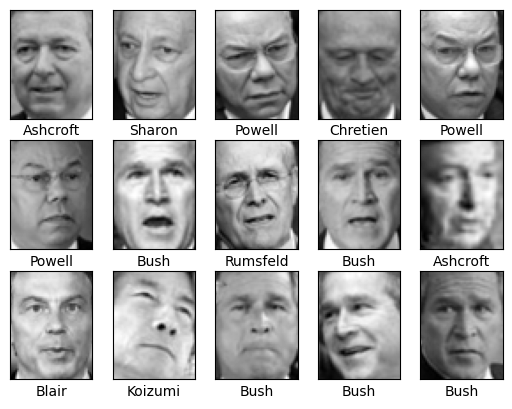

In [4]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

Крупнее

(-0.5, 46.5, 61.5, -0.5)

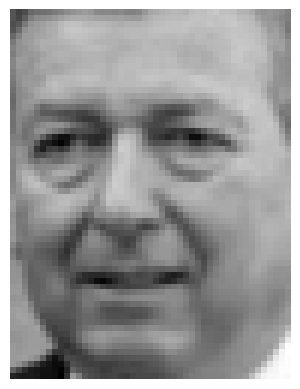

In [5]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [6]:
people = df['label'].unique()

print('Число различных людей:', len(people))

Число различных людей: 12


Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

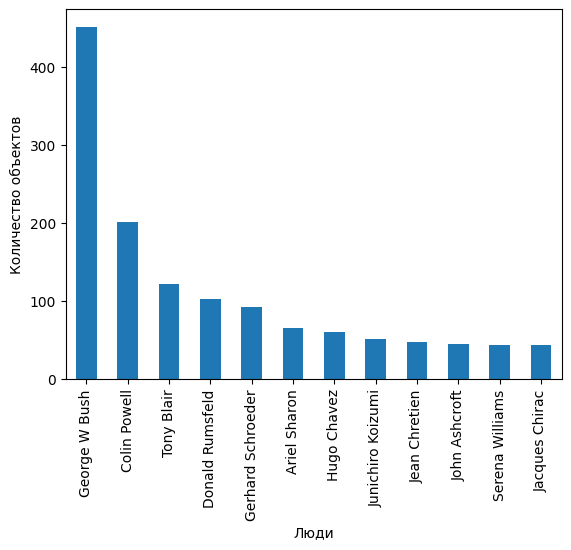

In [7]:
# построим гистограмму распределения объектов по классам
counts = df['label'].value_counts()

counts.plot(kind='bar')
plt.xlabel('Люди')
plt.ylabel('Количество объектов')
plt.xticks(rotation=90)
plt.show()

In [8]:
# вычислим долю объектов каждого класса
proportion = df['label'].value_counts(normalize=True)
round(proportion, 3)

,proportion
label,
George W Bush,0.340
Colin Powell,0.152
Tony Blair,0.092
Donald Rumsfeld,0.078
Gerhard Schroeder,0.070
Ariel Sharon,0.049
Hugo Chavez,0.045
Junichiro Koizumi,0.038
Jean Chretien,0.035


На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [9]:
average_vectors = df.groupby('label').mean().reset_index()
average_vectors.head()

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
1,Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
2,Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
3,George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
4,Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [10]:
# найдем координату с индексом 0 усредненного вектора, соответствующего Ariel Sharon
print('Координата усредненного вектора с индеком 0:', round(average_vectors[average_vectors['label'] == 'Ariel Sharon']['0'][0], 3))

Координата усредненного вектора с индеком 0: 0.501


Используя усредненные векторы, постройте изображения всех людей из набора данных.

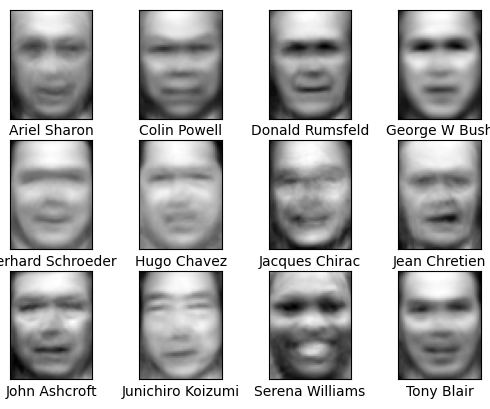

In [11]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(average_vectors.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=lbl)

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [12]:
# построим матрицу "схожести" объектов на основе их усредненных векторов
labels = average_vectors['label']
vectors = average_vectors.drop(columns=['label']).values

similarity_matrix = cosine_similarity(vectors)
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
similarity_df

label,Ariel Sharon,Colin Powell,Donald Rumsfeld,George W Bush,Gerhard Schroeder,Hugo Chavez,Jacques Chirac,Jean Chretien,John Ashcroft,Junichiro Koizumi,Serena Williams,Tony Blair
label,,,,,,,,,,,,
Ariel Sharon,1.000000,0.997854,0.996752,0.994814,0.993415,0.989612,0.993172,0.995977,0.995131,0.987816,0.987774,0.995362
Colin Powell,0.997854,1.000000,0.997700,0.996409,0.995470,0.992776,0.995131,0.996490,0.996295,0.990409,0.988370,0.997367
Donald Rumsfeld,0.996752,0.997700,1.000000,0.996645,0.996309,0.991954,0.995152,0.997448,0.995308,0.988584,0.986606,0.997292
George W Bush,0.994814,0.996409,0.996645,1.000000,0.997728,0.996353,0.996223,0.993516,0.997465,0.993667,0.985307,0.997331
Gerhard Schroeder,0.993415,0.995470,0.996309,0.997728,1.000000,0.997621,0.997229,0.994118,0.996986,0.993774,0.985748,0.998107
Hugo Chavez,0.989612,0.992776,0.991954,0.996353,0.997621,1.000000,0.995185,0.989890,0.994794,0.993828,0.983244,0.996131
Jacques Chirac,0.993172,0.995131,0.995152,0.996223,0.997229,0.995185,1.000000,0.993350,0.996172,0.994746,0.983479,0.996284
Jean Chretien,0.995977,0.996490,0.997448,0.993516,0.994118,0.989890,0.993350,1.000000,0.993907,0.986172,0.982785,0.995850
John Ashcroft,0.995131,0.996295,0.995308,0.997465,0.996986,0.994794,0.996172,0.993907,1.000000,0.993632,0.987354,0.996908


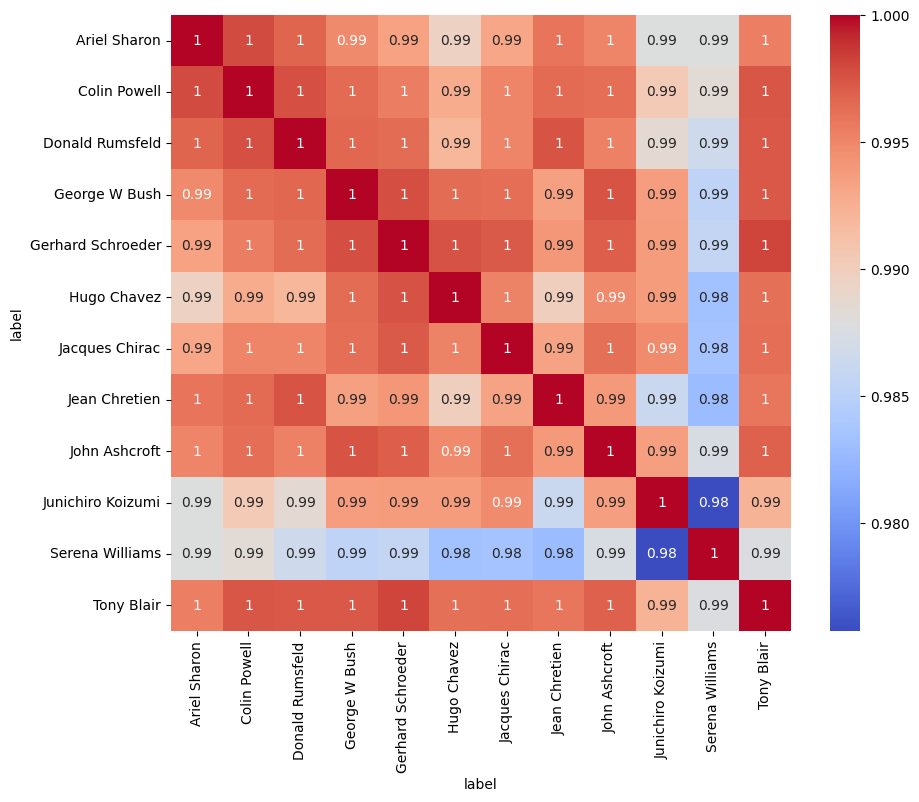

In [13]:
# визуализируем матрицу с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', cbar=True)
plt.show()

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [14]:
# опреледим значение косинусного сходства между парой усредненных векторов Donald Rumsfeld и Serena Williams
print('Косинусное сходство:', round(similarity_df.loc['Donald Rumsfeld', 'Serena Williams'], 3))

Косинусное сходство: 0.987


# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [15]:
# разобьем набор данных на обучающую и тестовую выборки с параметрами test_size=0.2, random_state=5
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=5, stratify=df['label'])

print('Shapes', '    X', '       y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes     X        y
train (1060, 2914) (1060,)
test  (266, 2914) (266,)


## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [16]:
# обучим модель SVC() на тренировочном наборе данных со следующими параметрами: kernel='linear', random_state=5
svm = SVC(kernel='linear', random_state=5).fit(X_train, y_train)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [17]:
prediction = svm.predict(X_test)

print('f1_score:', round(f1_score(y_test, prediction, average='weighted'), 3))

f1_score: 0.741


В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [18]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]

cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   1.7s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   1.8s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   2.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   2.5s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   3.6s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   2.3s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   2.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   2.3s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [19]:
cv.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'sigmoid',
 'random_state': 5}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [20]:
prediction = cv.best_estimator_.predict(X_test)

print('f1_score:', round(f1_score(y_test, prediction, average='weighted'), 3))

f1_score: 0.771


## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [21]:
# обучим модель PCA(svd_solver='full') на тренировочных данных
pca = PCA(svd_solver='full').fit(X_train)

In [22]:
# определим минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше 0.95
n_comp = (pca.explained_variance_ratio_.cumsum() > 0.95).argmax() + 1
print(f'Минимальное количество ГК: {n_comp}')

Минимальное количество ГК: 173


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [23]:
# обучим модель PCA(svd_solver='full', n_components=n_comp) на тренировочных данных
pca = PCA(svd_solver='full', n_components=n_comp).fit(X_train)

In [24]:
# применим полученное преобразование для тренировочных и тестовых данных
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [25]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [26]:
cv.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 5}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [27]:
prediction = cv.best_estimator_.predict(X_test)

print('f1_score:', round(f1_score(y_test, prediction, average='weighted'), 3))

f1_score: 0.755


Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.